### Coding Bayesian AB Tests in Python to Boost your App or Website Conversions
[Access Link](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd)

In [7]:
%matplotlib inline
import pymc3 as pm
import seaborn as sb
import math
n = 1000  # Total number of users 
obs_v1 = 680 # First picture 
obs_v2 = 700 # Second picture 

> We'll use a __Beta__ distribution for the priors and a __Bernoulli__ distribution for the likelihood. 
>> The model needs to be defined within a context so place every command inside with pm.Model()

In probability theory and statistics, the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is a family of continuous probability distributions defined on the interval [0, 1] parametrized by two positive shape parameters, denoted by α and β, that appear as exponents of the random variable and control the shape of the distribution.


# Alpha Beta Destribution 

In [8]:

def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

def plot_Beta_Alpha(alpha,beta):
    xs = [x / 100.0 for x in range(0, 100)]
    plt.figure(figsize=(8,8))
    plt.plot(xs,[beta_pdf(x, alpha, beta) for x in xs],'-',label='alpha={0},beta={1}'.format(alpha,beta))
    plt.legend(loc=1)
    plt.grid()
    plt.show()

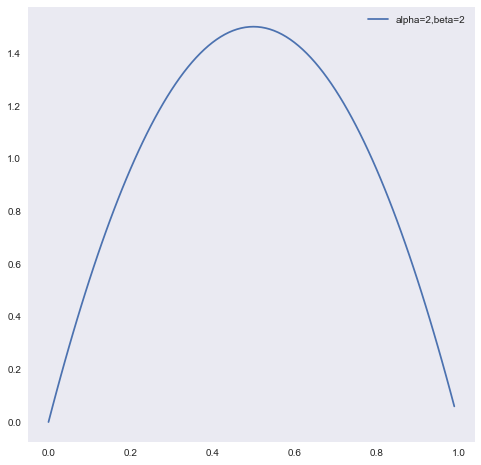

In [9]:
plot_Beta_Alpha(alpha=2,beta=2)

In [15]:
n = 1000  # Total number of users 
obs_v1 = 680 # First picture 
obs_v2 = 700 # Second picture 

with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=2, beta=2)
    prior_v2 = pm.Beta('prior_v2', alpha=2, beta=2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n, p=prior_v2, observed=obs_v2)
    
   

> __alpha__ and __beta__ are the parameters of the beta distribution (we choose the value 2 just to give a tiny preference to draw at first), __n__ is the number of users in the experiment up to that moment, __p__ is the probability of converting users and observed is the actual number of users who converted.

>> Now that we have setup the distributions for each variation, we can operate with them to come up with interesting results. Let's create two variables that will contain the difference and the relation between the variations.

In [ ]:
with model:
     # define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)

>> We can operate the priors the same way we do with scalar variables because they only contain samplings of our distributions!

> To finish up our model definition we need to provide the number of draws, the sampling method step and the initial state for MCMC start.

In [19]:
# inference
with model:
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)


logp = -154.95, ||grad|| = 269.07: 100%|██████████| 7/7 [00:00<00:00, 55.74it/s]   
100%|██████████| 50500/50500 [00:25<00:00, 1944.22it/s]


> It's good practice to analyze the distribution of all parameters in the model as well as their sampling value per iteration. Make sure you run the code above and then let's plot that.

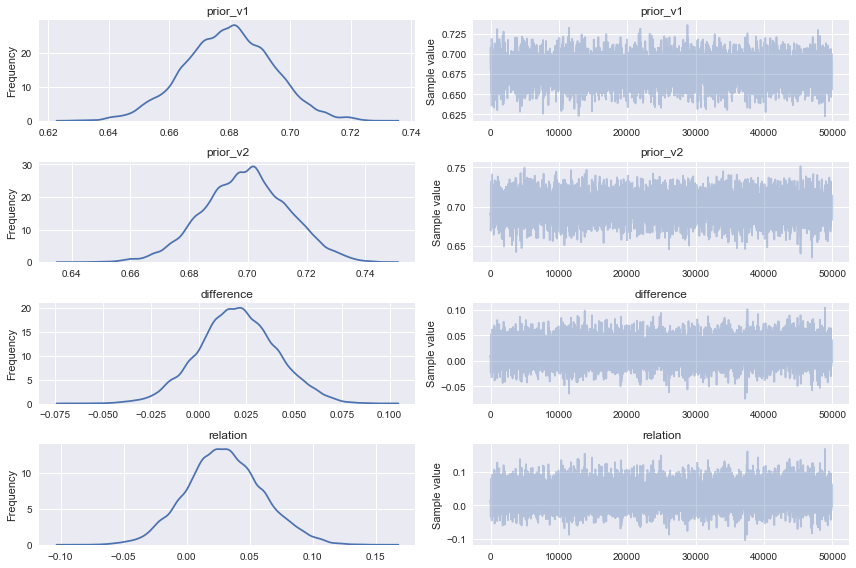

In [21]:
_ = pm.traceplot(trace[0:], grid=True)


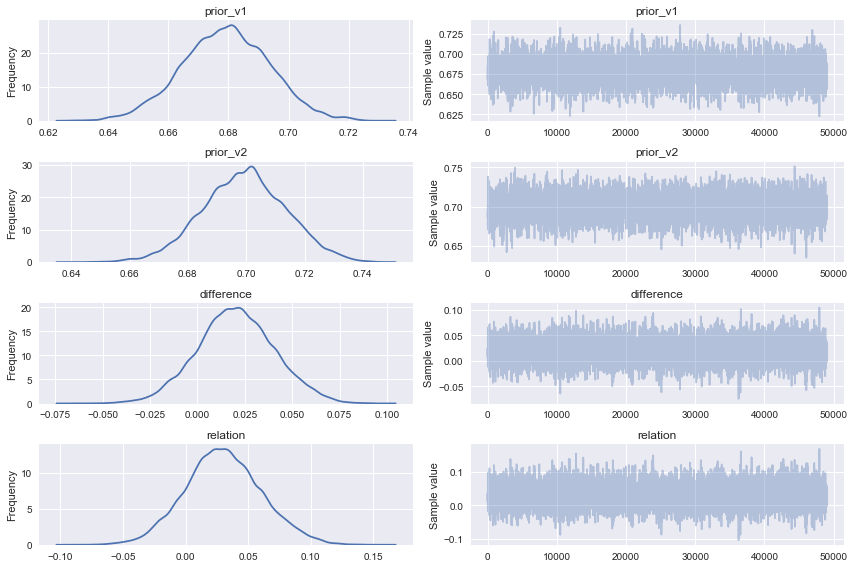

In [22]:
_ = pm.traceplot(trace[1000:], grid=True)


>> We skip the first 1000 samples because those can be noisy. Let's check the output of the command above.

>> On the left column you see the distributions and on the right column you see the sampling value for each step.


>>Finally we can plot a histogram that give us the confidence that one variation is better than the other __(it's simply the area under the difference or relation curve for values above zero)__.

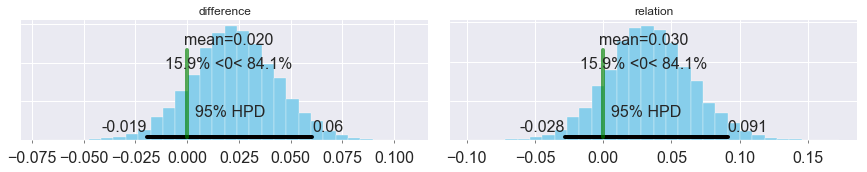

In [23]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

>> Looking at the difference or relation histogram we see we have __83% confidence__ that __variation 2__ is better than __variation 1__. If we have earlier defined a significance level of 5%, we can't declare a winner yet. We need to either capture more data or stop the experiment and call it a draw.

Next steps
==
Here we used a fixed value of users who did convert and thus our confidence output is just a number: 83%. Often times you want to follow your confidence metric up in a daily-basis so you could have a time-series graph containing on the x-axis the number of days since the experiment started and on the y-axis the confidence value. The graph looks like the one below:

<img src='dailyABtest.png' >

https://github.com/thibalbo/bayesian-abtests-examples